In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train = np.loadtxt(open("X_train.csv", "rb"), delimiter=",")
T_train = np.loadtxt(open("T_train.csv", "rb"), delimiter=",")
X_test = np.loadtxt(open("X_test.csv", "rb"), delimiter=",")
T_test = np.loadtxt(open("T_test.csv", "rb"), delimiter=",")

In [3]:
def plot_class(D, T, title):
    clr = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for c in range(1, 6):
        x = D[T==c][:, 0]
        y = D[T==c][:, 1]
        plt.scatter(x, y, color=clr[c], alpha=0.8, marker='.')
    plt.title(title)
    plt.show()

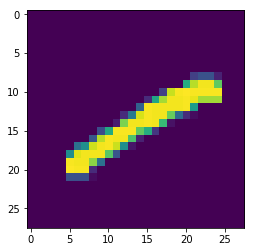

In [4]:
plt.imshow(X_train[1000].reshape(28,28))
# plt.gray()
plt.show()

# PCA projection

### sklearn

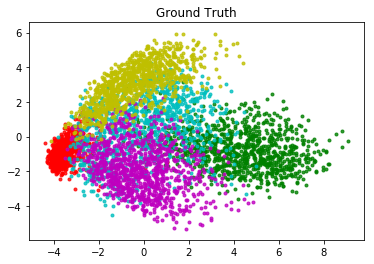

In [5]:
# Principal Component Analysis
from numpy import array
from sklearn.decomposition import PCA

# create the PCA instance
pca = PCA(2)

# fit on data
pca.fit(X_train)

# transform data
B = pca.transform(X_train)

title = "Ground Truth"
plot_class(B, T_train, title)

### scratch

In [30]:
def pca(X,k):
    
    #mean of each feature
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    
    # Calculate norm
    norm_X=X-mean
    
    # Calculate covariance matrix
    cov_matrix=np.dot(np.transpose(norm_X),norm_X)
    
    # Calculate the eigenvectors and eigenvalues
    # Sort it according to eigenvalues ascending
    eig_val, eig_vec = np.linalg.eig(cov_matrix)
    idx = eig_val.argsort()[::-1] 
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    
    # select the top k eig_vec
    final_eigvec=-np.array([ele for ele in eig_vec.T[ : k]])
    
    # Project to lower dimension
    data=np.dot(norm_X,np.transpose(final_eigvec))
    
    return np.real(data)

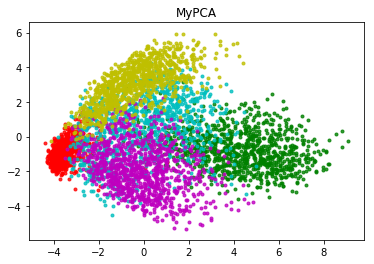

In [31]:
myPCA = pca(X_train, 2)

title = "MyPCA"
plot_class(myPCA, T_train, title)

# LDA project

Project on a planar :  
y(i) = w.T * x(i)  
1. y(i) : (2, 1)  
2. w : (784, 2)  
3. x(i) : (784, 1) 
---
Y = X * W  
1. Y : (5000, 2)  
2. X : (5000, 784)
3. W : (784, 2)

### sklearn

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


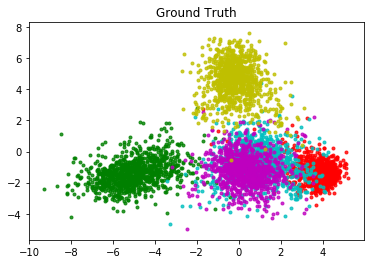

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X = X_train
y = T_train

res = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)

title = "Ground Truth"
plot_class(res, T_train, title)

### scratch

In [9]:
# Seperate data of different classes into array 'classes'
classes = []
for c in range(1, 6):
    tmp = []
    for idx, data in enumerate(X_train):
        if T_train[idx] == c:
            tmp.append(data)
    classes.append(tmp)
classes = np.array(classes)
# print(classes.shape)

In [10]:
# Calculate class mean
mean = []
for class_datas in classes:
    mean.append(np.mean(class_datas, axis=0))
mean = np.array(mean)
# print(mean.shape)

In [11]:
# Sw : within-class scatter
# Calculate Sw
Sw = np.zeros((784, 784))
for c, class_datas in enumerate(classes):
    for data in class_datas:
        tmp = data - mean[c]
        tmp = np.expand_dims(tmp, axis=0)
        Sw = Sw + np.matmul( tmp.T , tmp )
# print(Sw.shape)

In [12]:
# Sb : between-class scatter
# Calculate Sb
total_mean = np.mean(X_train, axis=0)
Sb = np.zeros((784, 784))
for c in range(len(classes)):
    class_len = len(classes[c])
    tmp = mean[c] - total_mean
    tmp = np.expand_dims(tmp, axis=0)
    Sb = Sb + class_len*np.matmul( tmp.T , tmp )
# print(Sb.shape)

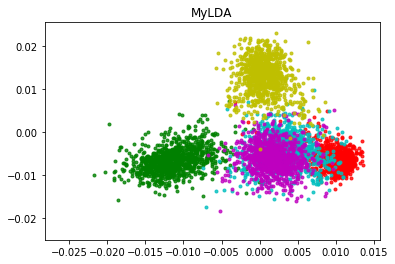

In [23]:
# Calculate eigenvalue, eigenvector of (Sw)**-1 * Sb
Sw_inv = np.linalg.pinv(Sw)
Target = np.matmul(Sw_inv, Sb)
eig_val, eig_vec = np.linalg.eig(Target)
idx = eig_val.argsort()[::-1]
eig_val = eig_val[idx]
eig_vec = eig_vec[:,idx]

# select the top k eig_vec
final_eigvec = np.real(np.array([ele for ele in eig_vec.T[: 2]]))
myLDA = np.matmul(X_train, final_eigvec.T)

title = "MyLDA"
plot_class(myLDA, T_train, title)

---

# att faces

(112, 92, 3)


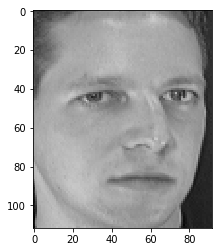

In [14]:
img = cv2.imread('att_faces/s1/2.pgm')
print(img.shape)
plt.imshow(img)
plt.show()

In [50]:
dataArray = np.empty((0, 112*92))

# Read all images into array 'dataArray'
for root, dirs, files in os.walk('att_faces'):
    for directory in dirs:
        for root_, dirs_, files_ in os.walk('att_faces/'+directory):
            for file in files_:
                img = cv2.imread('att_faces/'+directory+'/'+file, 0)
                img_row = np.array(img, dtype='float64').flatten()
                img_row = np.expand_dims(img_row, axis=0)
                dataArray = np.vstack((dataArray, img_row))
# print(dataArray.shape)

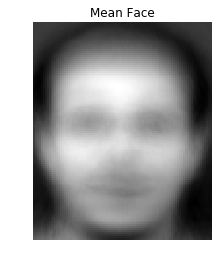

In [51]:
# Calculate Mean Face
dataAvg = np.mean(dataArray, axis=0)
tmp = dataAvg.reshape(112, 92)
plt.imshow(tmp, cmap='gray')
plt.axis('off')
plt.title("Mean Face")
plt.show()

In [67]:
# Random pick 10 faces
from random import sample
rand_idx = sample(range(1,len(dataArray)), 10)
print(rand_idx)

[100, 354, 292, 383, 139, 209, 5, 370, 74, 393]


In [82]:
# Number of eigenvectors to pick
eig_k = 70

# Calculate the eigenvalue, eigenvector of At*A
# However, the shape of At*A is 10304*10304
# Since it is too large, we calculate A*At instead
dataDis = dataArray - dataAvg
A_AT = np.cov(dataDis)
eig_val, eig_vec = np.linalg.eig(A_AT)
idx = eig_val.argsort()[::-1]
eig_val = eig_val[idx]
eig_vec = eig_vec[:, idx]
eig_vec = eig_vec.T[:eig_k]

In [83]:
eig_faces = np.matmul(eig_vec, dataDis)

# Normalize eigenfaces again since we multiply dataDis again
for i, eig_face in enumerate(eig_faces):
    eig_faces[i] = eig_faces[i] / np.linalg.norm(eig_face)

# Reshape eigenfaces to the image size
eig_faces = eig_faces.reshape(eig_k, 112, 92)

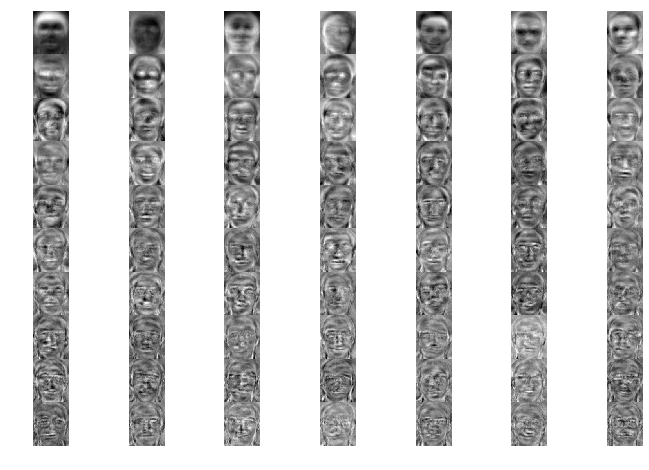

In [84]:
# Plot
plt.figure(figsize=(12,8))
for idx, eig_face in enumerate(eig_faces):
    plt.subplot(10,7,idx+1)
    plt.imshow(eig_face, cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [85]:
eig_faces = eig_faces.reshape(eig_k, 10304)

# Project dataDis to vector of eigenfaces
# Inorder to build Weight Matrix
# Each random-pick has k weights for k eigenfaces
W = []
for idx in rand_idx:
    tmp = []
    for eig_face in eig_faces:
        tmp.append(np.dot(dataDis[idx], eig_face))
    W.append(tmp)
W = np.array(W)
print(W.shape)

(10, 70)


In [86]:
# Reconstructing the random-pick faces
# For each image, (DataAvg + w[i]*eigenfaces[i]) will be the final image
res = []
for W_ in W:
    tmp = np.copy(dataAvg)
    for idx, w in enumerate(W_):
        tmp += w*eig_faces[idx]
    res.append(tmp)
res = np.array(res)
print(res.shape)

(10, 10304)


In [ ]:
# Plot
res = res.reshape(10, 112, 92)

plt.figure(figsize=(12,8))
for i, idx in enumerate(rand_idx):
    plt.subplot(2,5, i+1)
    plt.imshow(dataArray[idx].reshape(112, 92), cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

print('\n---------\n')

plt.figure(figsize=(12,8))
for idx, res_ in enumerate(res):
    plt.subplot(2,5, idx+1)
    plt.imshow(res_, cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()